In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from keras.datasets import mnist

from architectures.protoshotxai import ProtoShotXAI
from utils.ploting_function import xai_plot

In [2]:
model_path_pretrained = '../trained_models/adv_pretrained_conv_mnist/'
base_model = load_model(model_path_pretrained)

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train,axis = 3)/255
x_test = np.expand_dims(x_test,axis=3)/255

data = pickle.load(open("../data/MNIST_adversarial.pkl", "rb"))
x_test_adv = data['x_test_adv']
y_test_adv = data['y_test_adv']

example_index = 3495
query_adv = np.expand_dims(x_test_adv[example_index,:,:,0],axis=2)
query_adv = np.expand_dims(query_adv,axis=0)
query_adv = np.expand_dims(query_adv,axis=0)

In [4]:
adv_sample = x_test_adv[example_index,:,:,:]
adv_samples = np.tile(np.expand_dims(np.copy(adv_sample),axis=0),(10000,1,1,1))
adv_sum = np.sum(np.abs(adv_samples-x_test),axis=(1,2,3))
adv_where = np.where(adv_sum == np.min(adv_sum))[0][0]

query_benign = np.expand_dims(x_test[adv_where,:,:,0],axis=2)
query_benign = np.expand_dims(query_benign,axis=0)
query_benign = np.expand_dims(query_benign,axis=0)

(-0.5, 27.5, 27.5, -0.5)

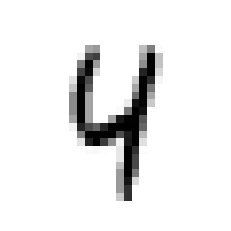

In [5]:
plt.imshow(1-x_test[adv_where,:,:,0],'gray')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

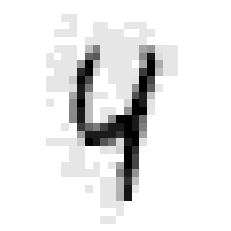

In [26]:
plt.imshow(1-x_test_adv[example_index,:,:,0],'gray')
plt.axis('off')

In [7]:
protoshot = ProtoShotXAI(base_model)
shot = 1000

In [10]:
print(np.argmax(base_model.predict(query_adv[0])))
print(np.argmax(base_model.predict(query_benign[0])))


5
4


In [11]:
f = np.linspace(0, 128, 128)

## Adversarial 4, prototype 4
iclass = 4 # prototype 4
support_data = x_train[y_train == iclass]
support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
support_data = np.expand_dims(np.copy(support_data),axis=0)

s_feature_adv_proto4, q_feature_adv_proto4, den = protoshot.compute_features(support_data,query_adv,iclass)
s_feature_adv_proto4 = s_feature_adv_proto4.flatten()
q_feature_adv_proto4 = q_feature_adv_proto4.flatten()
den_adv_proto4 = den[0][0]

## Benign 4, prototype 4
s_feature_benign_proto4, q_feature_benign_proto4, den = protoshot.compute_features(support_data,query_benign,iclass)
s_feature_benign_proto4 = s_feature_benign_proto4.flatten()
q_feature_benign_proto4 = q_feature_benign_proto4.flatten()
den_benign_proto4 = den[0][0]

## Adversarial 4, prototype 5
iclass = 5 # prototype 4
support_data = x_train[y_train == iclass]
support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
support_data = np.expand_dims(np.copy(support_data),axis=0)

s_feature_adv_proto5, q_feature_adv_proto5, den = protoshot.compute_features(support_data,query_adv,iclass)
s_feature_adv_proto5 = s_feature_adv_proto5.flatten()
q_feature_adv_proto5 = q_feature_adv_proto5.flatten()
den_adv_proto5 = den[0][0]

## Benign 4, prototype 5
s_feature_benign_proto5, q_feature_benign_proto5, den = protoshot.compute_features(support_data,query_benign,iclass)
s_feature_benign_proto5 = s_feature_benign_proto5.flatten()
q_feature_benign_proto5 = q_feature_benign_proto5.flatten()
den_benign_proto5 = den[0][0]


In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure()
# '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'

fig = make_subplots(rows=2, cols=2, vertical_spacing = 0.15, horizontal_spacing = 0.15,
    specs=[[{"secondary_y": True}, {"secondary_y": True}],
    [{"secondary_y": True}, {"secondary_y": True}]], 
    subplot_titles=("Class 4 Features for Benign 4", 
    "Class 5 Features for Benign 4",
    "Class 4 Features for Adversarial 4 (Class: True 4, Predicted 5)",
    "Class 5 Features for Adversarial 4 (Class: True 4, Predicted 5)"))
fig.update_annotations(font_size=24)


## Adversarial 4, prototype 4
fig.add_trace(go.Scatter(
    x=f, y=s_feature_adv_proto4/np.sqrt(np.sum(s_feature_adv_proto4*s_feature_adv_proto4)),
    name='Support prototype feature components',
    line=dict(color="#636EFA", width=6),
), secondary_y=False, row=2, col=1)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_adv_proto4/np.sqrt(np.sum(q_feature_adv_proto4*q_feature_adv_proto4)),
    name='Query feature components',
    line=dict(color="#00CC96", width=4),
), secondary_y=False, row=2, col=1)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_adv_proto4*s_feature_adv_proto4/den_adv_proto4,
    name='ProtoShotXAI components',
    line=dict(color="#EF553B", width=2),
), secondary_y=True, row=2, col=1)
fig.update_xaxes(title_text="Feature Number", range = [1,128],row=2, col=1)
fig.update_yaxes(title_text="Feature Weight", range = [-0.6,0.6],secondary_y=False, row=2, col=1)
fig.update_yaxes(title_text="ProtoShotXAI Weight", range = [-0.12,0.12],secondary_y=True, row=2, col=1)


## Benign 4, prototype 4
fig.add_trace(go.Scatter(
    x=f, y=s_feature_benign_proto4/np.sqrt(np.sum(s_feature_benign_proto4*s_feature_benign_proto4)),
    name='support prototype feature components',
    line=dict(color="#636EFA", width=6),
    showlegend=False,
), secondary_y=False, row=1, col=1)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_benign_proto4/np.sqrt(np.sum(q_feature_benign_proto4*q_feature_benign_proto4)),
    name='benign features',
    line=dict(color="#00CC96", width=4),
    showlegend=False,
), secondary_y=False, row=1, col=1)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_benign_proto4*s_feature_benign_proto4/den_benign_proto4,
    name='ProtoShot distance components',
    line=dict(color="#EF553B", width=2),
    showlegend=False,
), secondary_y=True, row=1, col=1)
fig.update_xaxes(title_text="Feature Number", range = [1,128],row=1, col=1)
fig.update_yaxes(title_text="Feature Weight", range = [-0.6,0.6],secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="ProtoShotXAI Weight", range = [-0.12,0.12],secondary_y=True, row=1, col=1)


## Adversarial 4, prototype 5
fig.add_trace(go.Scatter(
    x=f, y=s_feature_adv_proto5/np.sqrt(np.sum(s_feature_adv_proto5*s_feature_adv_proto5)),
    name='Support prototype feature components',
    line=dict(color="#636EFA", width=6),
    showlegend=False,
), secondary_y=False, row=2, col=2)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_adv_proto5/np.sqrt(np.sum(q_feature_adv_proto5*q_feature_adv_proto5)),
    name='Adversarial feature components',
    line=dict(color="#00CC96", width=4),
    showlegend=False,
), secondary_y=False, row=2, col=2)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_adv_proto5*s_feature_adv_proto5/den_adv_proto5,
    name='ProtoShot distance components',
    line=dict(color="#EF553B", width=2),
    showlegend=False,
), secondary_y=True, row=2, col=2)
fig.update_xaxes(title_text="Feature Number", range = [1,128],row=2, col=2)
fig.update_yaxes(title_text="Feature Weight", range = [-0.6,0.6],secondary_y=False, row=2, col=2)
fig.update_yaxes(title_text="ProtoShotXAI Weight", range = [-0.12,0.12],secondary_y=True, row=2, col=2)

## Benign 4, prototype 5
fig.add_trace(go.Scatter(
    x=f, y=s_feature_benign_proto5/np.sqrt(np.sum(s_feature_benign_proto5*s_feature_benign_proto5)),
    name='support prototype feature components',
    line=dict(color="#636EFA", width=6),
    showlegend=False,
), secondary_y=False, row=1, col=2)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_benign_proto5/np.sqrt(np.sum(q_feature_benign_proto5*q_feature_benign_proto5)),
    name='benign features',
    line=dict(color="#00CC96", width=4),
    showlegend=False,
), secondary_y=False, row=1, col=2)

fig.add_trace(go.Scatter(
    x=f, y=q_feature_benign_proto5*s_feature_benign_proto5/den_benign_proto5,
    name='cosine distance components',
    line=dict(color="#EF553B", width=2),
    showlegend=False,
), secondary_y=True, row=1, col=2)
fig.update_xaxes(title_text="Feature Number", range = [1,128],row=1, col=2)
fig.update_yaxes(title_text="Feature Weight", range = [-0.6,0.6],secondary_y=False, row=1, col=2)
fig.update_yaxes(title_text="ProtoShotXAI Weight", range = [-0.12,0.12],secondary_y=True, row=1, col=2)

fig.update_layout(
    font=dict(
        size=18,
    )
)
fig.update_layout(title_font_size=20)


fig.show()

import plotly.io as pio
pio.write_image(fig, './results/Adversarial_MNIST/Adversarial_MNIST_Features.png', width=2000, height=800)



In [20]:
n_samples = 1000
rand_seq = np.random.permutation(np.shape(x_test_adv)[0])
rand_seq = rand_seq[:n_samples]
scores_benign = np.zeros((n_samples,10))
scores_adv = np.zeros((n_samples,10))
true_vals = np.zeros(n_samples)

progress_bar = True
for irand in tqdm(range(n_samples),disable=(not progress_bar)):
    rand_int = rand_seq[irand] 
    true_vals[irand] = y_test[rand_int]
    
    query_adv = np.expand_dims(x_test_adv[rand_int,:,:,0],axis=2)
    query_adv = np.expand_dims(query_adv,axis=0)
    query_adv = np.expand_dims(query_adv,axis=0)

    query_benign = np.expand_dims(x_test[rand_int,:,:,0],axis=2)
    query_benign = np.expand_dims(np.copy(query_benign),axis=0)
    query_benign = np.expand_dims(np.copy(query_benign),axis=0)

    for iclass in range(10):
        support_data = x_train[y_train == iclass]
        support_data = support_data[np.random.permutation(support_data.shape[0])[:shot]]
        support_data = np.expand_dims(np.copy(support_data),axis=0)
        scores_adv[irand,iclass] = protoshot.compute_score(support_data,query_adv,iclass)
        scores_benign[irand,iclass] = protoshot.compute_score(support_data,query_benign,iclass)


100%|██████████| 1000/1000 [05:26<00:00,  3.07it/s]


In [22]:
mask_adv = np.zeros((n_samples,10))
mask_adv[np.arange(n_samples),np.argmax(scores_adv,axis=1)] = 1

mask_benign = np.zeros((n_samples,10))
mask_benign[np.arange(n_samples),true_vals.astype(int)] = 1

in_class_benign = scores_benign[mask_benign==1]
in_class_adv = scores_adv[mask_adv==1]

In [23]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=in_class_benign, name='in-class scores for regular digits', histnorm='probability',
        xbins=dict( 
        start=0.0,
        end=1.0,
        size=0.02))
)
fig.add_trace(go.Histogram(x=in_class_adv, name='in-class scores for adversarial digits', histnorm='probability',
        xbins=dict( 
        start=0.0,
        end=1.0,
        size=0.02))
)

# The two histograms are drawn on top of another
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.update_xaxes(title_text="ProtoShotXAI Score")
fig.update_yaxes(title_text="Probability")

fig.update_layout(
    title={
        'text': "Histogram of In-Class Scores",
        'y':0.85,
        'x':0.35,
        'xanchor': 'center',
        },
    font=dict(
        size=18,
    )
)
fig.update_layout(title_font_size=20)


import plotly.io as pio
pio.write_image(fig, './results/Adversarial_MNIST/Adversarial_MNIST_Histrograms.png', width=1000, height=500)
fig.show()

In [24]:
n_points = 1000
thresh = np.arange(n_points)/n_points
ROC_x = np.zeros_like(thresh)
ROC_y = np.zeros_like(thresh)
for i in range(n_points):
    ithresh = thresh[i]
    ROC_y[i] = np.sum(in_class_benign >= ithresh)/n_points
    ROC_x[i] = np.sum(in_class_adv >= ithresh)/n_points

In [25]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ROC_x, y=ROC_y,line=dict(width=6)))

fig.update_xaxes(title_text="False Positive Rate",range=[-0.01,1])
fig.update_yaxes(title_text="Adversarial Detection Rate")

fig.update_layout(
    title={
        'text': "ROC Curve for MNIST Adversarial Detection",
        'y':0.87,
        'x':0.49,
        'xanchor': 'center',
        },
    font=dict(
        size=18,
    )
)
fig.update_layout(title_font_size=20)


import plotly.io as pio
pio.write_image(fig, './results/Adversarial_MNIST/Adversarial_MNIST_ROC.png', width=500, height=500)
fig.show()

